<a href="https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note: This notebook is a work in progress & will be updated continuously over the next week or so before it's ready - 18 May 2021

# Time series forecasting in TensorFlow

The goal of this notebook is to get you familiar with working with time series data.

It won't cover all of the time series field but by the end you will get a fairly good overview of things to consider for time series problems...

Outline:
* Get data (a time series)
* Format data
  * Turn data into a windowed dataset
  * Training/test sets for time series
  * Univariate - Bitcoin's price history
  * Multivariate - Bitcoin's price history + block size
* Model data
  * Baseline - naive forecasting
  * Baseline 2 - random forest regressor
  * Deep model - fully connected
  * Sequence models
    * LSTM
    * Conv1D
  * N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf
* Evaluating a time series model
  * MAE
  * MSE
  * RMSE etc...
* Uncertainty estimates
  * Coconut uncertainty - epistemic uncertainty
  * Subway uncertainty - aleatory uncertainty
* Why forecasting is BS (turkey problem) - https://youtu.be/hRwimmE2wEk
  * Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20 
  * Closed system: try it out 
* Exercises
* Extra-curriculum
  * Time series book - https://otexts.com/fpp2/accuracy.html 


## TODO: What is a time series problem?

* Forecasting
* Classification

## TODO: Get data

Let's predict the price of Bitcoin! Data source: https://www.coindesk.com/price/bitcoin

> **Note:** This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

See this tweet for reference: https://twitter.com/marksaroufim/status/1366871736604532739?s=20

TODO (upload to Google Storage/GitHub): Data: https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv?dl=0

In [1]:
!wget https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-05-19 03:05:28--  https://www.dropbox.com/s/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv [following]
--2021-05-19 03:05:28--  https://www.dropbox.com/s/raw/hoexgnrk44uco0a/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc73b407e90c4b0d0bac40d58244.dl.dropboxusercontent.com/cd/0/inline/BOxFrkirunmRp9bsG7g7Zjezfh_mdLfw7D_LdtNQ1u3rkufOkhiOLtlOAvsu8VyGeMhwKSxqiagpHquK4qUdOpS91yfZwoWDBJwWjJVTyD92BshuFKk1nqi4XGxM85zuXa_EKrlSf2MNFEVyNKKyzr3D/file# [following]
--2021-05-19 03:05:29--  https://uc73b407e90c4b0d0bac40d58244.dl.dropboxusercontent.com/cd/0/inline/

In [2]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.654990,124.304660,124.751660,122.563490
2013-10-02,BTC,125.455000,123.654990,125.758500,123.633830
2013-10-03,BTC,108.584830,125.455000,125.665660,83.328330
2013-10-04,BTC,118.674660,108.584830,118.675000,107.058160
2013-10-05,BTC,121.338660,118.674660,121.936330,118.005660
...,...,...,...,...,...
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [13]:
# TODO: time series often may not have very many samples (e.g. monthly = only 12 per year, daily = 365 per year... etc)
# Deep learning algorithms usually flourish with lots of data (1000's of samples)
len(df)

2787

In [4]:
# Only want closing price
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [5]:
bitcoin_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2787 non-null   float64
dtypes: float64(1)
memory usage: 43.5 KB


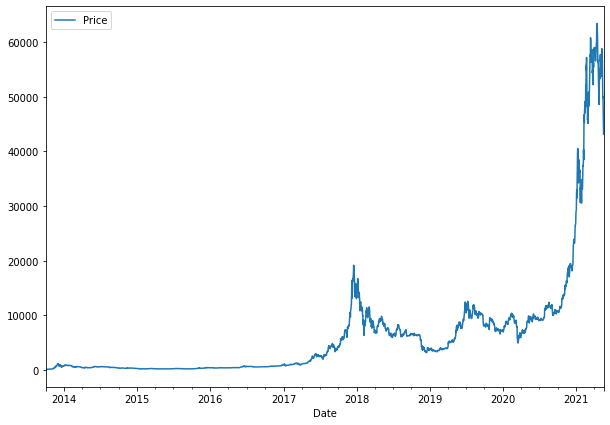

In [6]:
bitcoin_prices.plot(figsize=(10, 7));

In [7]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [8]:
# Windowing data
bitcoin_prices["Shift+1"] = bitcoin_prices["Price"].shift(1)
bitcoin_prices.head()

,Price,Shift+1
Date,,
2013-10-01,123.65499,NaN
2013-10-02,125.45500,123.65499
2013-10-03,108.58483,125.45500
2013-10-04,118.67466,108.58483
2013-10-05,121.33866,118.67466


### Importing time series as a CSV

In [9]:
# Importing with Python CSV - https://realpython.com/python-csv/
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

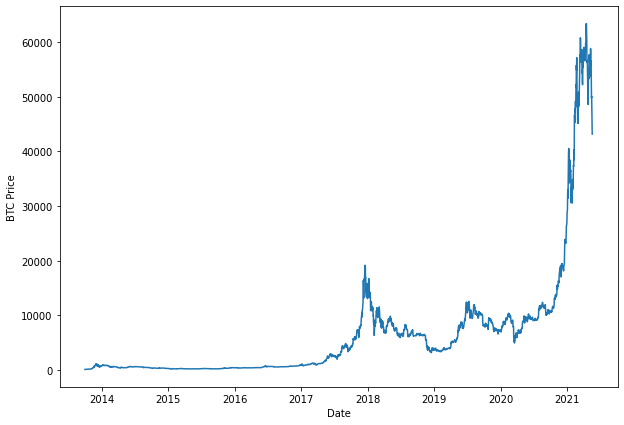

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, np.array(btc_price))
plt.xlabel("Date")
plt.ylabel("BTC Price");

## TODO: Format data 

* Turn data into a windowed dataset
* Training/test sets for time series
* Univariate - Bitcoin's price history
* Multivariate - Bitcoin's price history + block size

### TODO: Create train & test sets for time series

* Note: cannot do random split, time series will buckle under this (using future values in the past)
* Need to make train set: values from past, test set: values from "future"

In [14]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [15]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

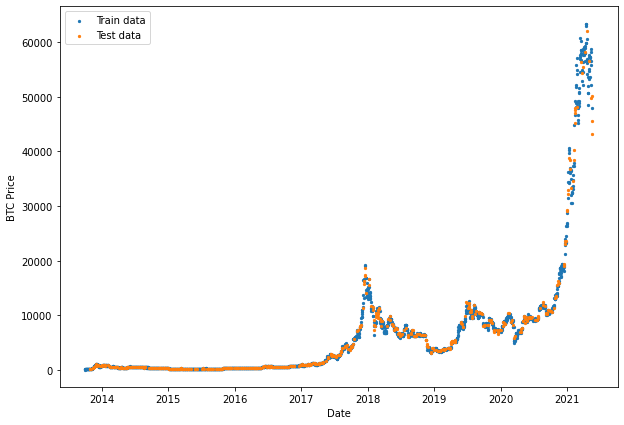

In [16]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

* TODO: Note: time series forecasting can often have many less data points than traditional deep learning projects (e.g. the entire history of BTC daily price data = only ~3000 samples)

* TODO: What kind of steps should we predict? E.g. 80/20 split is that realisitic? You may want to use all of the data up until the last week...

In [17]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

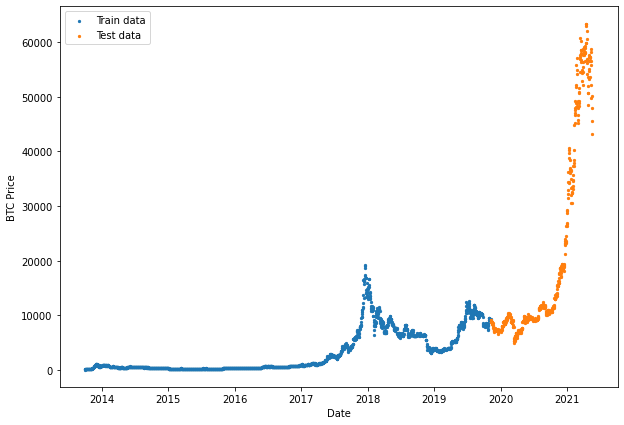

In [18]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

## TODO: Model data

* Baseline - naive forecasting
* Baseline 2 - moving average
* Baseline 3 - random forest regressor
* Deep model - fully connected
* Sequence models
* LSTM
* Conv1D
* N-Beats algorithm - https://arxiv.org/pdf/1905.10437.pdf

### Model 0: Naive forecast

Naive forecast = Use the previous timestep to predict the next timestep

$$\hat{y}_{t} = y_{t-1}$$ 

In [19]:
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

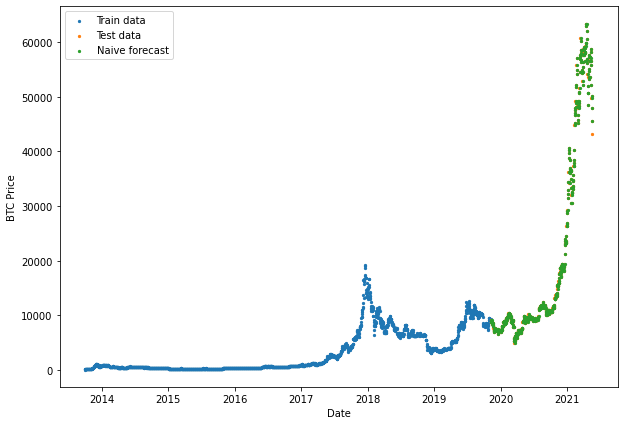

In [20]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.scatter(X_test[1:], naive_forecast, s=5, label="Naive forecast")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show();

In [21]:
def plot_zoomed_in(new_preds=None, new_preds_name="New Preds", zoom_timesteps=100, plot_naive=True):
  # Plot naive forecast zoomed in
  plt.figure(figsize=(10, 7))
  plt.plot(X_test[-zoom_timesteps:], y_test[-zoom_timesteps:], label="Test data")
  if plot_naive:
    plt.plot(X_test[1:][-zoom_timesteps:], naive_forecast[-zoom_timesteps:], label="Naive forecast")
  if new_preds != None:
    plt.plot(X_test[-zoom_timesteps:], new_preds[-zoom_timesteps:], label=new_preds_name)
  plt.xlabel("Date")
  plt.ylabel("BTC Price")
  plt.legend()
  plt.show();

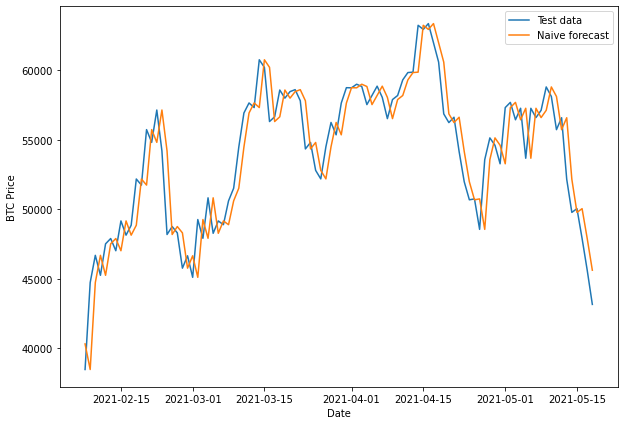

In [22]:
plot_zoomed_in()

## TODO: Evaluating a time series model

TK - this can be a function for each model (compares predictions to ground truth...)

In [23]:
import tensorflow as tf

In [24]:
def scaled_mape(y_true, y_pred):
  return tf.reduce_mean(200 * (tf.abs(y_true - y_pred)/(tf.abs(y_true) + tf.abs(y_pred))))

In [25]:
def evaluate_preds(y_true, y_pred, use_window=True, window_size=10):
  # TODO: does this need to go from Numpy -> tensorflow -> Numpy??
  # TODO: could use sklearn to fix the above

  # Account for window size
  if use_window:
    y_true = y_true[window_size:]
  
  # Turn into tensors
  y_true = tf.constant(y_true, dtype=tf.float32)
  y_pred = tf.constant(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  smape = scaled_mape(y_true, y_pred)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "mape": mape.numpy(),
          "smape": smape.numpy()}

In [26]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast,
                               use_window=False)
naive_results

{'mae': 567.9802, 'mape': 2.516525, 'mse': 1147547.0, 'smape': 2.5180573}

In [27]:
# TODO: Make evaluation function for various metrics...

## Windowing dataset

Why do we window?

TODO: We can turn our time series data into a **supervised learning problem**: use windows of the past to predict the future.

In [28]:
X_train, y_train

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', ...,
        '2019-11-05T00:00:00.000000000', '2019-11-06T00:00:00.000000000',
        '2019-11-07T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
        9326.59962378, 9335.75240233]))

In [29]:
X_test[:10], y_test[:10]

(array(['2019-11-08T00:00:00.000000000', '2019-11-09T00:00:00.000000000',
        '2019-11-10T00:00:00.000000000', '2019-11-11T00:00:00.000000000',
        '2019-11-12T00:00:00.000000000', '2019-11-13T00:00:00.000000000',
        '2019-11-14T00:00:00.000000000', '2019-11-15T00:00:00.000000000',
        '2019-11-16T00:00:00.000000000', '2019-11-17T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

Want:

```
# Window for a week (univariate time series)
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [266]:
# Make windows of size 10
WINDOW_SIZE = 10
HORIZON = 1 # predict 1 step at a time

In [267]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  [1, 2, 3, 4, 5, 6] -> ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [268]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=10, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
  window_indexes = window_step + np.expand_dims(np.arange((len(x)+1)-(window_size+horizon)), axis=0).T # create 2D array of windows of size window_size
  windowed_array = x[window_indexes] # get the original array indexed with windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [269]:
len(y_train)

2229

In [270]:
# Create supervised datasets (use 10 timesteps (WINDOW_SIZE) to predict next 1 timestep (HORIZON))
train_windows, train_labels = make_windows(y_train, window_size=WINDOW_SIZE, horizon=HORIZON)
test_windows, test_labels = make_windows(y_test, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116, 125.27966, 125.9275 , 126.38333],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966, 125.9275 , 126.38333, 135.24199]]), array([[125.27966],
        [125.9275 ],
        [126.38333],
        [135.24199],
        [133.20333]]))

In [271]:
len(train_windows[0])

10

### TODO: Model 2: Random Forest Regressor

In [235]:
# TODO: ... why doesn't this work?

## TODO: Model X: Dense model 

In [236]:
import tensorflow as tf
from tensorflow.keras import layers

In [237]:
len(train_windows), len(test_windows)

(2219, 548)

In [238]:
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(1)                              
], name="model_1_dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels))

Epoch 1/10
70/70 [==============================] - 1s 4ms/step - loss: 3084.0808 - val_loss: 1318.6444
Epoch 2/10
70/70 [==============================] - 0s 2ms/step - loss: 241.9701 - val_loss: 1191.6680
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 175.5864 - val_loss: 1091.5194
Epoch 4/10
70/70 [==============================] - 0s 2ms/step - loss: 181.3572 - val_loss: 994.0839
Epoch 5/10
70/70 [==============================] - 0s 2ms/step - loss: 150.9893 - val_loss: 819.8408
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 161.9060 - val_loss: 923.5942
Epoch 7/10
70/70 [==============================] - 0s 2ms/step - loss: 164.1407 - val_loss: 963.3075
Epoch 8/10
70/70 [==============================] - 0s 2ms/step - loss: 173.3283 - val_loss: 744.3494
Epoch 9/10
70/70 [==============================] - 0s 2ms/step - loss: 131.3962 - val_loss: 926.9908
Epoch 10/10
70/70 [==============================] - 0s 2ms/step - loss: 134.2

In [239]:
# Evaluate
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1043.0604


1043.0604248046875

In [240]:
# Make predictions
model_1_preds = tf.squeeze(model_1.predict(test_windows))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8965.792 , 8797.307 , 8792.09  , 8594.366 , 8500.657 , 8201.584 ,
       7912.922 , 7734.8105, 7436.4976, 7475.8057], dtype=float32)>

In [241]:
model_1_preds[:10], y_test[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8965.792 , 8797.307 , 8792.09  , 8594.366 , 8500.657 , 8201.584 ,
        7912.922 , 7734.8105, 7436.4976, 7475.8057], dtype=float32)>,
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

In [242]:
len(model_1_preds), len(y_test)

(548, 558)

In [243]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8965.792 , 8797.307 , 8792.09  , 8594.366 , 8500.657 , 8201.584 ,
       7912.922 , 7734.8105, 7436.4976, 7475.8057], dtype=float32)>

In [244]:
test_labels[:10], test_labels[-10:]

(array([[8537.33965197],
        [8205.80636599],
        [8118.4885358 ],
        [8074.84317361],
        [7612.7405735 ],
        [7262.11053495],
        [7303.40575852],
        [7041.73293642],
        [7211.86180875],
        [7141.06944869]]), array([[58788.20967893],
        [58102.19142623],
        [55715.54665129],
        [56573.5554719 ],
        [52147.82118698],
        [49764.1320816 ],
        [50032.69313676],
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [245]:
len(y_test)

558

In [246]:
558/10

55.8

In [247]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

In [248]:
y_test[10:20]

array([8537.33965197, 8205.80636599, 8118.4885358 , 8074.84317361,
       7612.7405735 , 7262.11053495, 7303.40575852, 7041.73293642,
       7211.86180875, 7141.06944869])

In [249]:
WINDOW_SIZE

10

In [250]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_1_preds,
                                 use_window=True,
                                 window_size=WINDOW_SIZE)
model_1_results

{'mae': 1043.0605, 'mape': 5.0917964, 'mse': 3113610.0, 'smape': 4.911267}

In [251]:
naive_results

{'mae': 567.9802, 'mape': 2.516525, 'mse': 1147547.0, 'smape': 2.5180573}

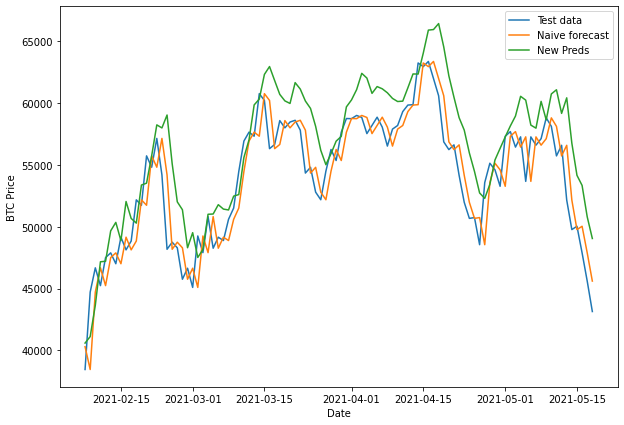

In [252]:
# Plot model_1 results
plot_zoomed_in(new_preds=model_1_preds, plot_naive=True)

## TODO: Model X: Larger window + horizon

TK - What happens if we make a larger window & horizon?

* TK - Window & horizon values are values you can tune...

In [516]:
HORIZON = 14 # predict two weeks at a time
WINDOW_SIZE = 140 # use 140 timesteps in the past

In [517]:
train_windows, train_labels = make_windows(y_train, window_size=WINDOW_SIZE, horizon=HORIZON)
test_windows, test_labels = make_windows(y_test, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows[0], train_labels[0]

(array([ 123.65499,  125.455  ,  108.58483,  118.67466,  121.33866,
         120.65533,  121.795  ,  123.033  ,  124.049  ,  125.96116,
         125.27966,  125.9275 ,  126.38333,  135.24199,  133.20333,
         142.76333,  137.92333,  142.95166,  152.55183,  160.33883,
         164.31499,  177.63333,  188.29716,  200.70166,  180.355  ,
         175.03166,  177.6965 ,  187.15983,  192.75666,  197.4    ,
         196.02499,  198.04883,  198.93233,  200.543  ,  210.3075 ,
         225.02   ,  248.25333,  262.32666,  294.48699,  331.10325,
         285.8875 ,  304.97974,  338.137  ,  357.48   ,  402.954  ,
         409.10375,  420.21649,  437.29725,  510.6025 ,  693.65   ,
         531.54249,  574.71599,  681.33   ,  774.18   ,  746.19374,
         768.8475 ,  789.36475,  893.1815 ,  934.355  , 1068.363  ,
        1154.92593, 1099.51926, 1019.78966, 1028.845  , 1071.2848 ,
        1139.33083, 1004.61633,  759.43041,  689.81   ,  841.83966,
         916.77599,  967.42866,  866.29003,  911

In [518]:
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
])

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=5,
            validation_data=(test_windows, test_labels))

Epoch 1/5
65/65 [==============================] - 1s 5ms/step - loss: 1895.0439 - val_loss: 3550.1238
Epoch 2/5
65/65 [==============================] - 0s 2ms/step - loss: 565.9901 - val_loss: 2978.1265
Epoch 3/5
65/65 [==============================] - 0s 2ms/step - loss: 495.8392 - val_loss: 2604.2800
Epoch 4/5
65/65 [==============================] - 0s 2ms/step - loss: 438.9620 - val_loss: 2537.1375
Epoch 5/5
65/65 [==============================] - 0s 2ms/step - loss: 445.1391 - val_loss: 2529.3965


In [519]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

13/13 [==============================] - 0s 1ms/step - loss: 2529.3965


2529.396484375

In [520]:
model_2_preds = model_2.predict(test_windows)
model_2_preds

array([[ 6602.0825,  6997.6167,  6448.9087, ...,  6590.9326,  6612.2607,
         6425.3823],
       [ 6699.1387,  6882.939 ,  5989.629 , ...,  6739.698 ,  6863.783 ,
         6344.4688],
       [ 6796.567 ,  6923.437 ,  6057.1597, ...,  6658.8765,  6709.9287,
         5994.527 ],
       ...,
       [53112.06  , 62615.555 , 58679.746 , ..., 54776.41  , 58278.586 ,
        58397.57  ],
       [55288.55  , 61839.152 , 59771.344 , ..., 56245.043 , 59131.21  ,
        59026.027 ],
       [56090.395 , 62968.98  , 58286.176 , ..., 56585.195 , 57638.46  ,
        57954.594 ]], dtype=float32)

In [521]:
model_2_preds.shape, test_labels.shape

((405, 14), (405, 14))

In [538]:
def evaluate_preds(y_true, y_pred, use_window=True, window_size=10):
  # Turn into tensors
  y_true = tf.constant(y_true, dtype=tf.float32)
  y_pred = tf.constant(y_pred, dtype=tf.float32)

  # Account for window size
  if use_window:
    y_true = y_true[window_size:]

  # If labels/preds are multi-dimensional (e.g. predicting more than 1 timestep, reshape for calculations)
  if y_true.ndim > 1:
    y_true = tf.reshape(y_true, [-1]) # flatten the input tensor
    y_pred = tf.reshape(y_pred, [-1])

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  smape = scaled_mape(y_true, y_pred)
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "mape": mape.numpy(),
          "smape": smape.numpy()}

In [542]:
# test_labels.ravel(), model_2_preds.ravel()

In [539]:
model_2_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_2_preds,
                                 use_window=False)
model_2_results

{'mae': 2529.3965, 'mape': 9.727565, 'mse': 16825896.0, 'smape': 10.112202}

In [484]:
model_1_results

{'mae': 1043.0605, 'mape': 5.0917964, 'mse': 3113610.0, 'smape': 4.911267}

In [485]:
naive_results

{'mae': 567.9802, 'mape': 2.516525, 'mse': 1147547.0, 'smape': 2.5180573}

In [486]:
len(y_test[140+14-1:]), len(tf.reduce_mean(model_2_preds, axis=1))

(405, 405)

In [493]:
y_test[140:HORIZON+WINDOW_SIZE]

array([6721.49539238, 6682.7800492 , 6229.48834283, 5922.48983509,
       6483.73944553, 6446.42134684, 6537.3364615 , 6850.55871169,
       6776.37009357, 6855.93326446, 6805.3622869 , 7278.24396977,
       7175.66747656, 7367.29339845])

In [525]:
len(y_test)

558

In [489]:
test_labels[0]

array([6721.49539238, 6682.7800492 , 6229.48834283, 5922.48983509,
       6483.73944553, 6446.42134684, 6537.3364615 , 6850.55871169,
       6776.37009357, 6855.93326446, 6805.3622869 , 7278.24396977,
       7175.66747656, 7367.29339845])

In [515]:
y_test[-14:]

array([53658.84312082, 57252.7021845 , 56583.84987917, 57107.12067189,
       58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

In [512]:
test_labels[-1]

array([53658.84312082, 57252.7021845 , 56583.84987917, 57107.12067189,
       58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

In [527]:
y_test[WINDOW_SIZE:-(len(y_test) % HORIZON)-1]

array([ 6721.49539238,  6682.7800492 ,  6229.48834283,  5922.48983509,
        6483.73944553,  6446.42134684,  6537.3364615 ,  6850.55871169,
        6776.37009357,  6855.93326446,  6805.3622869 ,  7278.24396977,
        7175.66747656,  7367.29339845,  7321.81661389,  6866.39818901,
        6873.84849516,  7043.43886352,  6889.86377235,  6887.55490783,
        6718.79995028,  7166.58281714,  7065.08238904,  7277.14058556,
        7185.87030343,  6856.14643454,  6904.4757727 ,  7118.38874792,
        7562.03283175,  7497.86176383,  7542.3034007 ,  7624.85378592,
        7776.50754257,  7761.75878408,  8773.10648796,  8767.67262337,
        8853.77448401,  8963.0575578 ,  8904.71381654,  8887.50589259,
        8978.28358712,  9371.68427279,  9900.67886662,  9917.24841434,
        9617.51819493,  8786.65518165,  8608.12524504,  8815.2312449 ,
        9330.9864847 ,  9757.29658559,  9362.63555697,  9418.91855051,
        9684.70195935,  9723.68015045,  9719.48085448,  9540.88656658,
      

In [526]:
tf.keras.metrics.mean_absolute_error(y_test[WINDOW_SIZE:-(len(y_test) % HORIZON)-1], # account for window sizes/cutoff
                                     tf.reduce_mean(model_2_preds, axis=1))

<tf.Tensor: shape=(), dtype=float32, numpy=1481.0415>

In [510]:
len(y_test[WINDOW_SIZE:-(len(y_test) % HORIZON)-1])

405

In [508]:
len(y_test) % HORIZON

12

In [499]:
len(y_test) % 14

12

In [497]:
len(y_test)/14

39.857142857142854

### Model 3: Dense (1 horizon, 140 window)

* -> How does a larger window effect a smaller horizon?
* -> Model 1 looked at predicting horizon=1 with window=140
* -> Model 2: horizon=14, window=140
* -> Model 3: horizon=1, window=140
* -> Compare them all...

In [395]:
HORIZON = 1
WINDOW_SIZE = 140

train_windows, train_labels = make_windows(y_train, window_size=WINDOW_SIZE, horizon=HORIZON)
test_windows, test_labels = make_windows(y_test, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows[0], train_labels[0]

(array([ 123.65499,  125.455  ,  108.58483,  118.67466,  121.33866,
         120.65533,  121.795  ,  123.033  ,  124.049  ,  125.96116,
         125.27966,  125.9275 ,  126.38333,  135.24199,  133.20333,
         142.76333,  137.92333,  142.95166,  152.55183,  160.33883,
         164.31499,  177.63333,  188.29716,  200.70166,  180.355  ,
         175.03166,  177.6965 ,  187.15983,  192.75666,  197.4    ,
         196.02499,  198.04883,  198.93233,  200.543  ,  210.3075 ,
         225.02   ,  248.25333,  262.32666,  294.48699,  331.10325,
         285.8875 ,  304.97974,  338.137  ,  357.48   ,  402.954  ,
         409.10375,  420.21649,  437.29725,  510.6025 ,  693.65   ,
         531.54249,  574.71599,  681.33   ,  774.18   ,  746.19374,
         768.8475 ,  789.36475,  893.1815 ,  934.355  , 1068.363  ,
        1154.92593, 1099.51926, 1019.78966, 1028.845  , 1071.2848 ,
        1139.33083, 1004.61633,  759.43041,  689.81   ,  841.83966,
         916.77599,  967.42866,  866.29003,  911

In [414]:
# Build model
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(1)
])

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=10,
            validation_data=(test_windows, test_labels))

Epoch 1/10
66/66 [==============================] - 1s 4ms/step - loss: 1544.6417 - val_loss: 2565.3826
Epoch 2/10
66/66 [==============================] - 0s 2ms/step - loss: 395.5449 - val_loss: 2548.2158
Epoch 3/10
66/66 [==============================] - 0s 2ms/step - loss: 384.8590 - val_loss: 1579.2136
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 428.6699 - val_loss: 1769.8199
Epoch 5/10
66/66 [==============================] - 0s 2ms/step - loss: 293.0366 - val_loss: 1541.7451
Epoch 6/10
66/66 [==============================] - 0s 2ms/step - loss: 295.3796 - val_loss: 2311.8735
Epoch 7/10
66/66 [==============================] - 0s 3ms/step - loss: 302.5395 - val_loss: 1676.8278
Epoch 8/10
66/66 [==============================] - 0s 2ms/step - loss: 297.3793 - val_loss: 2011.1776
Epoch 9/10
66/66 [==============================] - 0s 2ms/step - loss: 293.3749 - val_loss: 1369.4457
Epoch 10/10
66/66 [==============================] - 0s 2ms/step - loss:

In [397]:
model_3.evaluate(test_windows, test_labels)

14/14 [==============================] - 0s 1ms/step - loss: 1068.2009


1068.200927734375

In [400]:
model_3_preds = model_3.predict(test_windows)

In [411]:
model_3_results = evaluate_preds(y_true=test_labels,
                                 y_pred=model_3_preds,
                                 use_window=False)
model_3_results

{'mae': 1068.2013, 'mape': 3.9055905, 'mse': 3570920.8, 'smape': 3.8755755}

In [412]:
model_1_results, model_2_results, model_3_results

({'mae': 1043.0605, 'mape': 5.0917964, 'mse': 3113610.0, 'smape': 4.911267},
 {'mae': 2685.0935, 'mape': 10.624958, 'mse': 18249514.0, 'smape': 11.210111},
 {'mae': 1068.2013, 'mape': 3.9055905, 'mse': 3570920.8, 'smape': 3.8755755})

## TODO: Make future forecasts...

* TODO
  * Make forecasting better (how can I forecast on an arbitrary amount of steps)
  * Create evaluation method for larger windows/horizons
  * Build more modelling experiments
  * Create multivariate time series
  * Create TensorFlow windowing function

* Forecasts can't be compared to anything... because they're a forecast... derp

In [415]:
WINDOW_SIZE

140

In [ ]:
# TODO: Create make forecast function with:
# Can forecast on any model
# Can forecast on any time series (gets formatted to be same as the model's requirements)

In [450]:
# Make forecast with one model... 
model_3_forecast = model_3.predict(tf.expand_dims(y_test[-model_3.input_shape[-1]:], axis=0))
model_3_forecast

array([[51037.02]], dtype=float32)

In [451]:
def make_forecast(model, input_data):
  """
  Uses model to make forecasts on input_data.
  """
  forecast = model.predict(tf.expand_dims(input_data[-model.input_shape[-1]:], axis=0)) # make future predictions on last timestep(s) of input_data
  return tf.squeeze(forecast).numpy()

In [454]:
model_2_forecast = make_forecast(model_2, y_test)
model_2_forecast

array([53904.688, 43581.746, 53670.637, 51078.867, 45989.836, 47447.473,
       44555.715, 46859.6  , 54127.32 , 54640.65 , 52999.043, 52226.145,
       46463.242, 45323.86 ], dtype=float32)

In [457]:
model_3_forecast = make_forecast(model_3, y_test)
model_3_forecast

51037.02

### TODO: Plot forecasts

* Need: 
  * horizon # of dates in future
  * forecast

In [443]:
# Last timestep of timesteps (currently in np.datetime64 format)
X_test[-1]

numpy.datetime64('2021-05-18T00:00:00.000000000')

In [444]:
def get_future_dates(start_date, horizon=1, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  horizon: number of day to add onto start date for range (int)
  offset: if offset=1 (default), original date is not included, if offset=0, original date is included
  """
  return np.arange(start_date + np.timedelta64(offset, "D"), start_date + np.timedelta64(horizon+1, "D"), dtype="datetime64[D]")

In [543]:
next_time_steps = get_future_dates(start_date=X_test[-1], horizon=HORIZON)

In [544]:
# Example of getting next two weeks
next_two_weeks = get_future_dates(start_date=X_test[-1], horizon=14)
next_two_weeks

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [545]:
model_2_forecast = np.insert(model_2_forecast, 0, y_test[-1]) 
future_dates = np.insert(next_two_weeks, 0, X_test[-1])

In [546]:
model_2_forecast, future_dates

(array([43144.473, 53904.688, 43581.746, 53670.637, 51078.867, 45989.836,
        47447.473, 44555.715, 46859.6  , 54127.32 , 54640.65 , 52999.043,
        52226.145, 46463.242, 45323.86 ], dtype=float32),
 array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'))

TODO: Fix the below graph to have model_2_preds... continued into model 2 forecast, want to have the windowed forecast plottable & then predictions being able to be made multiple steps into the future

In [528]:
tf.keras.metrics.mean_absolute_error(y_test[WINDOW_SIZE:-(len(y_test) % HORIZON)-1], # account for window sizes/cutoff
                                     tf.reduce_mean(model_2_preds, axis=1))

<tf.Tensor: shape=(), dtype=float32, numpy=1481.0415>

In [529]:
model_2_results

{'mae': 2529.3965, 'mape': 9.727565, 'mse': 16825896.0, 'smape': 10.112202}

In [551]:
y_test[140:140+14], test_labels[0]

(array([6721.49539238, 6682.7800492 , 6229.48834283, 5922.48983509,
        6483.73944553, 6446.42134684, 6537.3364615 , 6850.55871169,
        6776.37009357, 6855.93326446, 6805.3622869 , 7278.24396977,
        7175.66747656, 7367.29339845]),
 array([6721.49539238, 6682.7800492 , 6229.48834283, 5922.48983509,
        6483.73944553, 6446.42134684, 6537.3364615 , 6850.55871169,
        6776.37009357, 6855.93326446, 6805.3622869 , 7278.24396977,
        7175.66747656, 7367.29339845]))

In [549]:
tf.reduce_mean(model_2_preds[-100:], axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([36701.473, 36144.57 , 35764.348, 34901.656, 34843.71 , 35094.81 ,
       35132.727, 34703.82 , 34822.19 , 34917.02 , 35235.418, 35918.348,
       36537.855, 36705.363, 37077.176, 38421.293, 39489.344, 40080.098,
       40876.883, 42075.066, 43110.34 , 44393.844, 45216.777, 45956.57 ,
       46855.19 , 48068.395, 49270.723, 50073.617, 51104.812, 51841.305,
       51963.098, 52384.965, 52220.   , 51455.895, 51411.168, 51489.188,
       51131.52 , 50980.19 , 50987.875, 51007.54 , 51163.258, 51886.066,
       52521.082, 52356.008, 53245.973, 54041.48 , 55264.96 , 55964.742,
       56759.926, 57594.387, 58877.68 , 59014.035, 59824.086, 59583.305,
       59824.34 , 60218.43 , 59945.965, 59501.598, 58837.625, 58398.35 ,
       57354.477, 57350.035, 57393.535, 56191.32 , 56402.09 , 56915.77 ,
       56231.77 , 56628.395, 56597.395, 56858.844, 57405.73 , 58069.418,
       57892.56 , 57875.32 , 57569.188, 58106.938, 58683.445, 59460.043,
   

In [556]:
100-len(y_test) % HORIZON - 1

87

In [564]:
100+((len(y_test) % HORIZON) - 1)

111

In [565]:
X_test[-111]

numpy.datetime64('2021-01-28T00:00:00.000000000')

In [566]:
# Does indexing on this account for the lagging window???
(100+(len(y_test) % HORIZON) - 1)

111

[]

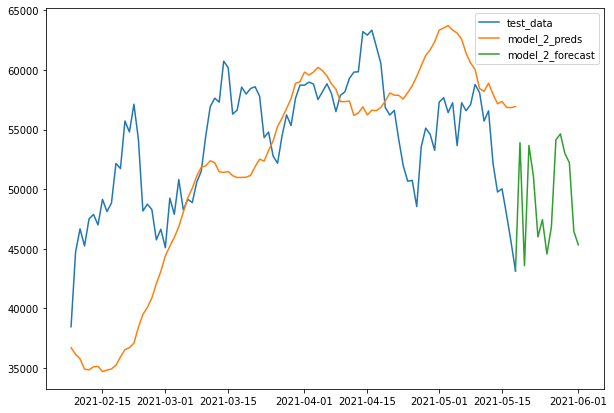

In [569]:
## TODO: Note the non-adjusted plot here...
# Plot forecast
plt.figure(figsize=(10, 7))
plt.plot(X_test[-100:], y_test[-100:], label="test_data")
# plt.plot(X_train, y_train)
plt.plot(X_test[-100:], tf.reduce_mean(model_2_preds[-100:], axis=1), label="model_2_preds")
plt.plot(future_dates, model_2_forecast.ravel(), label="model_2_forecast")
plt.legend()
plt.plot()

[]

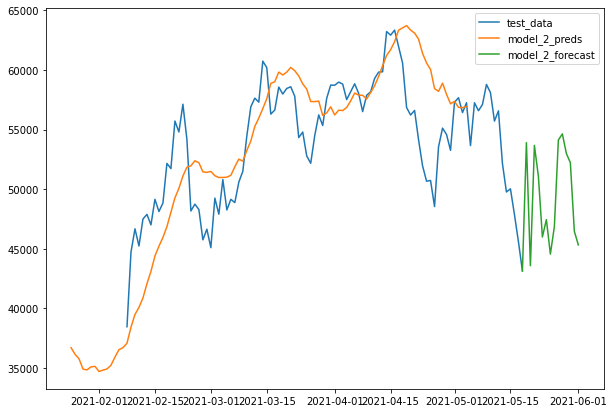

In [571]:
## TODO: Note the adjusted plot here...
# Plot forecast
plt.figure(figsize=(10, 7))
plt.plot(X_test[-100:], y_test[-100:], label="test_data")
# plt.plot(X_train, y_train)
plt.plot(X_test[-(100+HORIZON):-HORIZON], tf.reduce_mean(model_2_preds[-100:], axis=1), label="model_2_preds")
plt.plot(future_dates, model_2_forecast.ravel(), label="model_2_forecast")
plt.legend()
plt.plot()

# TODO: Make a multivariate time series 

Bitcoin price + halving events...

-> https://www.investopedia.com/bitcoin-halving-4843769

> Vigg_1991: For me … I use sensor data for predictions and forecasting … the toughest part of a time series has been .. when doing multivariate time series … some inputs may have larger scale compared to the target .. therefore do we de-trend all the data to keep them consistent or do we keep them them the way they are … because sometimes they lose the correlation between them once they are retreaded for prediction. How would you handle that ? Or is that important for deep learning predictions?

* inputs: larger scale compared to target
* detrend all the data to keep them consistent? Or keep the same way?
* sometimes they lose the correlation between them once they are de-trended 

## TODO: Make TensorFlow tf.data Windowed Dataset

In [ ]:
# TODO: Use entire time series to predict next step, compare to actual data 
# (e.g. revisit the prices in 1 week & see how the model goes)
# Start date: 18 May 2021
# End date: 25 May 2021 (revisit the updated prices here & see how wrong the model is...)

## TODO: Uncertainty estimates

### TODO: Model X: (model with Dropout to make MC Dropout model)...

# TODO: Why forecasting is BS (turkey problem)

TK - inject a turkey problem piece of data into the model & see how it effects (e.g. 1 data point that's 50x of outlier)

* See this video: https://youtu.be/hRwimmE2wEk
* Open system: beware (like fortune telling), see Mark Saroufim's tweet - https://twitter.com/marksaroufim/status/1366871736604532739?s=20
* Closed system: try it out

# TODO: Exercises

## TODO: Extra-curriculum